<a href="https://colab.research.google.com/github/lakshayt7/Bandit-Optimization-Algorithms/blob/main/Bandit%20Linear%20Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Bandit Linear Optimization**

Here we implement the algorithm given in the [paper](https://colt2008.cs.helsinki.fi/papers/123-Abernethy.pdf) which achives a regret bound of O(sqrt(Tlog(T))

In [ ]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import math
import cvxpy as cp
import random

In [ ]:
def reward(para, action):
    #Calculate Reward
    return para[0] + np.dot(para[1:], action)

In [ ]:
def random_uniform_vector(dims, r):
    u = np.random.uniform(size=(1, dims))
    u = u/np.linalg.norm(u)
    e = np.random.randint(r, size=1)
    return u

Since we are optimizing w.r.t a linear function we will create a random linear function for calculating the cost each time a player choses a vector.

In [ ]:
def Linear_fn(x, dims):
    #Create a random PSD matrix A. 
    b = np.random.rand(dimension, 1) #A random vector b
    d = np.random.rand(dimension, 1)
    e = np.random.randint(100, size=1)
    cost = np.dot(b.T,x)
    return cost, b
    #We now have a random quadratic convex function.

Here we minimize a regularizer which is a self-concordant barrier function to get the intial value of x.

In [ ]:
def mini(theta, c):
    try:
      x = cp.Variable(theta.shape)
      objective = cp.Minimize(-cp.atoms.affine.sum.sum(cp.atoms.elementwise.log.log(x + 1)))
      constraints = [cp.atoms.norm(x)<=c]
      prob = cp.Problem(objective, constraints)
      sol =  prob.solve()
      return x.value
    except:
      x = np.zeros(theta.shape)
      return x

This function minimizes a linear function using cvxpy.

In [ ]:
def minimum(b, d, theta, c):
    try:
      x = cp.Variable(theta.shape)
      objective = cp.Minimize(b.T@x)
      constraints = [cp.atoms.norm(x)<=c]
      prob = cp.Problem(objective, constraints)
      sol =  prob.solve()
      return x.value
    except:
      x = np.zeros(dimension)
      x = x.reshape(dimension, 1)
      return x

Adversary chose a random linear function and is used to calculate the cost.

In [ ]:
class Adversary:
    def __init__(self, cost_dict):
        self.costs = cost_dict
    def random_costs(self, action):
        #returns a random cost from the set of cost functions available to adversary
        n = np.shape(self.costs)[0]
        ind = random.randint(0,n-1)
        x = cp.Variable(np.shape(action)[0])
        cost = self.costs[ind]
        objective = cp.Minimize(cost[0] + np.squeeze(cost[1:])@x)
        constraints = [cp.atoms.norm(x)<=1]
        prob = cp.Problem(objective, constraints)
        sol =  prob.solve()
        return reward(self.costs[ind], action), sol
    def worst_costs(self, action):
        #returns worst cost out of set of cost functions available to Adversary
        n = np.shape(self.costs)[0]
        cost = reward(costs[0], action)
        for i in range(n):
            cost = max(cost, reward(costs[i], action))
        return cost
           

Intializing values required for the algorithm.

In [ ]:
def BanditLOpt(eta, n, ncosts, R, s, m, dimension, d, theta, cs):
  cov = 20*np.eye(d)
  mu = np.zeros((d))
  x = np.random.multivariate_normal(mu, cov, ncosts)
  costs = np.hstack((cs, x))
  A = Adversary(costs)
  w = np.zeros(dimension)
  w = w.reshape(dimension, 1)
  min_x = mini(w, R)
  x_t = min_x
  F = np.zeros(dimension)
  regret = []
  iteration = []
  real = []
  for t in range(0, n):
    #Calculating the Hessian of the regularizer.
    ##################################
    v = np.zeros(dimension)
    for j in range(dimension):
      v[j] = 1/(x_t[j]*x_t[j])
    v = np.array(v)
    H = np.diag(v)
    lamda, e = np.linalg.eig(H)
    ###################################

    #To simulate randomness we uniformly choose a eigenvector of the Hessian matrix.
    ###################################
    i = random.uniform(1,dimension)
    i = int(i)
    epsilon = np.random.binomial(1, 0.5)
    if epsilon == 0:
      epsilon = -1
    ###################################
    
    #To update and calculate the cost.
    ###################################
    y_t = x_t + epsilon*e[:,[i]]*math.sqrt(lamda[i])
    cost2, opt = A.random_costs(y_t)
    cost, b = Linear_fn(y_t, dimension)
    f_t = eta*(cost)*epsilon*math.sqrt(lamda[i])*e[:,[i]]
    s = s + float(cost)
    min_cost_vector = minimum(b, d, dimension, R)
    min_cost = float(np.dot(b.T,min_cost_vector))
    m = opt + m
    ###################################

    #To update x_t by solving the minimization problem given in the paper.
    ###################################
    if t == 0:
      F = f_t.T
    else:
      F = np.vstack((F,f_t.T))
    X = cp.Variable(w.shape)
    objective = cp.Minimize(eta*cp.atoms.affine.sum.sum(F@X)-cp.atoms.affine.sum.sum(cp.atoms.elementwise.log.log(X + 1)))
    constraints = [cp.atoms.norm(X) <= 6]
    prob = cp.Problem(objective, constraints)
    sol =  prob.solve()
    x_t = X.value
    x_t = x_t.reshape(dimension, 1)

    print(s-opt , opt, t)

    #For plotting
    #########################################################
    regret.append(s-opt)# + np.random.normal(3, np.sqrt(10)))
    iteration.append(t)
    real.append(math.sqrt(dimension*(t+1)*math.log(t+1)))
    #########################################################
  return regret, iteration

Regret variation with ETA:

Streaming output truncated to the last 5000 lines.
41.178454779373055 18.845068723079457 10
72.14334613840278 -6.888668859428323 11
50.59814285834303 18.845068723079457 12
35.034667900660736 40.075284980392226 13
43.378229058787014 35.88923035434996 14
41.49135252763891 41.780126081954435 15
95.93893578330895 -6.755632163759822 16
104.69586873474222 -6.888668859428323 17
102.70425008033416 0.7285658342709596 18
111.02656868429612 0.5530964092530386 19
75.03494784134824 40.075284980392226 20
79.72726161187907 40.075284980392226 21
107.04591234175268 18.845068723079457 22
137.7334783323925 -6.888668859428323 23
100.74506462694568 40.075284980392226 24
112.39670068641055 35.88923035434996 25
151.82810202025038 0.7285658342709596 26
161.85435339214422 0.7285658342709596 27
150.671196974954 18.845068723079457 28
171.78090661192869 0.7285658342709596 29
174.22837978483298 3.2479667516192015 30
183.44684844357474 0.7285658342709596 31
188.7689271172773 0.5530964092530386 32
162.45871253676935

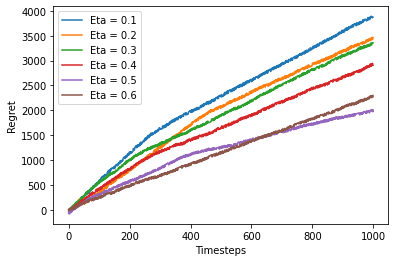

In [ ]:
n = 1000
dimension = 4
d = 4
theta = dimension
etas = [0.1 ,0.2 ,0.3, 0.4, 0.5, 0.6]
plt.xlabel('Timesteps')
plt.ylabel('Regret')
ncosts = 10
R = 1
cs = np.zeros((ncosts, 1))

for i in range(ncosts):
  c = random.randint(1, 50)
  cs[i] = c
for i in etas:
  y_cor, x_cor = BanditLOpt(i, n, ncosts, R, 0, 0, dimension, d, theta, cs)
  print('ETA = ',i)
  print('################################')
  plt.plot(x_cor, y_cor, label = "Eta = " + str(i) )
  plt.legend()
plt.legend()

5.5069225654090435 -3.672136294695342 0
6.526566054258193 0.06081613027733024 1
17.749365525228338 -3.672136294695342 2
24.157397301127645 -3.672136294695342 3
-10.192113486488033 34.81369618353147 4
35.55466580391794 -3.672136294695342 5
11.40655541423127 25.941209847126906 6
47.387808455036875 -3.672136294695342 7
23.214751448356317 25.941209847126906 8
70.72039126114637 -3.672136294695342 9
78.59869940425608 -3.672136294695342 10
57.350021297334784 25.941209847126906 11
52.35114411500519 34.81369618353147 12
90.5613035111954 -3.672136294695342 13
87.4654405100039 0.06081613027733024 14
65.81767050981435 25.941209847126906 15
62.53715541899266 34.81369618353147 16
96.86262321037876 1.7458528237037 17
99.23661134216327 1.7458528237037 18
104.38382283842031 0.06081613027733024 19
74.01917031094516 34.81369618353147 20
110.67395349515508 0.06081613027733024 21
114.36497659198841 -3.672136294695342 22
80.72925747680759 34.81369618353147 23
122.20388747267546 -3.672136294695342 24
122.965

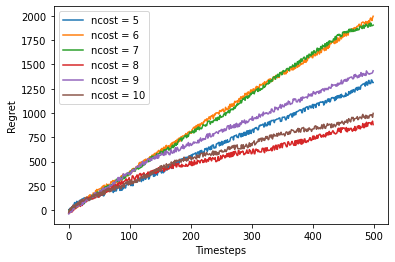

In [ ]:
n = 500
dimension = 4
d = 4
theta = dimension
ncostsS = [5 ,6 ,7 , 8, 9, 10]
plt.xlabel('Timesteps')
plt.ylabel('Regret')
# ncosts = 10
R = 1


for i in ncostsS:
  cs = np.zeros((i, 1))
  for j in range(i):
    c = random.randint(1, 50)
    cs[j] = c
  y_cor, x_cor = BanditLOpt(0.5, n, i, R, 0, 0, dimension, d, theta, cs)
  print('ncost = ',i)
  print('################################')
  plt.plot(x_cor, y_cor, label = "ncost = " + str(i) )
  plt.legend()
plt.legend()

Comparing with the theoritical bound.

-13.052399437791601 14.14888289283084 0
-9.404183149393315 12.68978588880962 1
9.220125371641402 -0.9498659631249309 2
2.8389473000310907 12.136881187001244 3
3.104256747211572 17.457884127392468 4
11.487406662011395 17.457884127392468 5
17.14524101934527 17.457884127392468 6
34.83953231274954 4.1320828196582475 7
43.35357693959467 -0.3932989678524663 8
33.90580477950612 14.14888289283084 9
51.944659256957785 -1.5703221907791818 10
43.9067504299293 12.136881187001244 11
43.611872232648246 17.457884127392468 12
53.06255854061234 14.14888289283084 13
73.90045500377565 0.7385612690487182 14
58.64953549163973 17.457884127392468 15
83.26701886666558 -0.9498659631249309 16
89.42227717643561 -0.3932989678524663 17
92.4453383168312 4.1320828196582475 18
103.81686570358883 -0.9498659631249309 19
105.48908401891205 -0.3932989678524663 20
98.16465428737267 14.14888289283084 21
104.5083840466074 12.136881187001244 22
122.32568913284345 0.7385612690487182 23
126.25741721678276 -0.3932989678524663 2

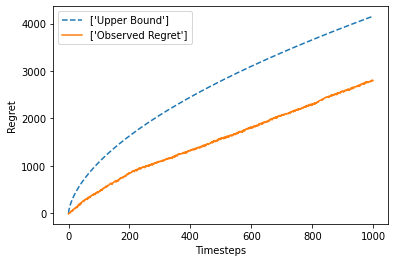

In [ ]:
n = 1000
dimension = 4
d = 4
theta = dimension
plt.xlabel('Timesteps')
plt.ylabel('Regret')
ncosts = 10
cs = np.zeros((ncosts, 1))
for i in range(ncosts):
  c = random.randint(1, 50)
  cs[i] = c
R = 1
ts = np.arange(n)
upp = np.sqrt((ts+1)*np.log(ts+1))*50
y_cor, x_cor = BanditLOpt(0.4, n, ncosts, R, 0, 0, dimension, d, theta, cs)
plt.plot((ts), (upp), '--')
plt.plot(np.array(x_cor), np.array(y_cor))
plt.legend((["Upper Bound"],["Observed Regret"]))
plt.show()